In [3]:
import os
import glob
import os.path as osp
import warnings
warnings.filterwarnings(action='ignore')
import multiprocessing
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torchsummary import summary

os.chdir('/VOLUME/nia_vent_asynchrony')
from module.datasets import preprocess_data#, set_dataloader, CustomDataset
from module.utils import load_and_stack_data, EarlyStopping
from model.VAE import VAE
from model.AsynchModel import AsynchModel
from module.metrics import calculate_any_metrics
from module.loss import calculate_vae_loss, calculate_bce_loss
import module.utils as cutils


In [5]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "2,3" 

In [6]:
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Current cuda device: 0
Count of using GPUs: 2


In [4]:
torch.cuda.is_available()

True

In [11]:
dest_dir = '/VOLUME/nia_vent_asynchrony/data/processed_data/tmp'

In [ ]:
dat_snu = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_with_label_snu.pkl')
dat_aju = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/aju/instance_with_label_aju_2022-08-23.pkl')
dat = pd.concat([dat_snu, dat_aju], axis=0)

In [ ]:
dat_snu = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_with_label_snu_239107_2022-08-25.pkl')
# dat = dat_snu
# dat_aju = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/aju/instance_with_label_aju_295433_2022-08-25.pkl')
dat = pd.concat([dat_snu, dat_aju], axis=0)
dat['wav_number'] = dat['wav_number'].astype(int)
dat['label'] = dat['label'].astype(int)

In [ ]:
dat = pd.concat([dat_snu, dat_aju], axis=0)
dat['wav_number'] = dat['wav_number'].astype(int)
dat['label'] = dat['label'].astype(int)

In [ ]:
print(dat_aju['flow_path'].nunique())
print(dat_aju['hospital_id_patient_id'].nunique())

In [ ]:
num_na = dat['data'].apply(lambda x: np.isnan(x).sum())

In [ ]:
num_na.value_counts().head(20)

In [ ]:
dat

In [ ]:
# dat = dat[num_na<480]
# dat_snu['data'].apply(lambda x : np.isnan(x).sum()).value_counts()
# dat = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_with_label_snu_3145286_2022-08-25.pkl')

In [ ]:
print(dat.groupby('hospital_id_patient_id')['label'].value_counts())

In [ ]:
# dat_bak=dat.copy()

In [ ]:
dat['split'] = 'train'
dat.loc[dat['hospital_id_patient_id']=='2-007','split'] = 'valid'
dat.loc[dat['hospital_id_patient_id']=='1-002','split'] = 'test'
dat.loc[dat['hospital_id_patient_id']=='2-002','split'] = 'test'

In [ ]:
print(dat['label'].value_counts())

In [ ]:
dat.columns

In [ ]:
pd.Series(label).value_counts()

In [ ]:
pd.Series(label).value_counts(normalize=True)

In [ ]:
dat['label'].value_counts()

In [ ]:
dat['label'].value_counts(normalize=True)

In [ ]:
label.shape

In [ ]:
feature.shape

In [ ]:

# # bce_loss = torch.nn.BCELoss(reduction='mean')

# def calculate_vae_loss(out, xi, batch_size=None):
#     bce_loss = torch.nn.BCEWithLogitsLoss(reduction='mean')
#     loss_r = bce_loss(out, xi)
#     # loss_r = ((out - xi)**2).sum()
#     loss_kl = torch.mean(.5 * torch.sum(mu.pow(2) + torch.exp(logVar) - 1 - logVar, 1))
#     # loss = torch.mean(loss_r) + loss_kl
#     loss = loss_r + loss_kl
#     return loss, loss_r, loss_kl

# def calculate_bce_loss(out, target, pos_weight=torch.tensor([5])):
#     if pos_weight is not None:
#         pos_weight = pos_weight.to(target)
#     bce_loss = torch.nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weight)
#     loss = bce_loss(out, target)
#     return loss


In [ ]:
nowDate = cutils.get_today_string()

In [ ]:
result_path = f'/VOLUME/nia_vent_asynchrony/result/baseline_220818/train/{nowDate}'
os.makedirs(result_path, exist_ok=True)
print(result_path)

In [ ]:
labelfreq = pd.concat([dat.groupby('split')['label'].value_counts(),
dat.groupby('split')['label'].value_counts(normalize=True)], axis=1)
labelfreq.columns = ['num', 'ratio']
print(labelfreq)
labelfreq.to_csv(osp.join(result_path, 'label_freq_trainvaltest.csv'))

In [ ]:
dat

In [ ]:
dat['split']='train'

In [ ]:
dat['data'].isna().sum()

In [ ]:
train_dataloader, val_dataloader, test_dataloader = preprocess_data(dat, set_train_weightedsampler=True, scale=True) # 34s

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
ventdys_model = AsynchModel(input_dim=2, padding_mode='replicate').to(device)

In [ ]:
summary(ventdys_model, input_size=(2, 3600), device='cuda')

In [ ]:
dat_snu = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_with_label_snu_239107_2022-08-25.pkl')
dat_aju = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/aju/instance_with_label_aju_295433_2022-08-25.pkl')
dat = pd.concat([dat_snu, dat_aju], axis=0)

In [ ]:
dat['split'] = 'train'
dat.loc[dat['hospital_id_patient_id']=='2-007','split'] = 'valid'
dat.loc[dat['hospital_id_patient_id']=='1-002','split'] = 'test'
dat.loc[dat['hospital_id_patient_id']=='2-002','split'] = 'test'

In [ ]:
dat['split'].value_counts()

In [ ]:
pd.crosstab(dat['label'], dat['split'])

In [ ]:
train_dataloader, val_dataloader, test_dataloader = preprocess_data(dat, set_train_weightedsampler=True, scale=True)

In [ ]:
result_path

In [ ]:
n_epochs = 50
learning_rate = 1e-3
optimizer = torch.optim.Adam(ventdys_model.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(patience = 10, verbose = True, path = result_path, checkpoint_name='ventdys_model.pt')


"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""
# 모델이 학습되는 동안 trainning loss를 track
train_losses = []
# 모델이 학습되는 동안 validation loss를 track
valid_losses = []
# epoch당 average training loss를 track
avg_train_losses = []
# epoch당 average validation loss를 track
avg_valid_losses = []


for epoch in range(n_epochs):
    print(f'Epoch {epoch}')

    ventdys_model.train()
    for i_step, data in enumerate(train_dataloader):
        xi, target = data
        xi = xi.to(device)
        target = target.to(device).squeeze(-1).squeeze(-1).float()
        out = ventdys_model(xi)

        loss = calculate_bce_loss(out[:,1], target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # print('step', i_step, 'loss', loss.item())
    print('epoch', epoch, 'loss', loss.item())
    
    ######################    
    # validate the model #
    ######################
    ventdys_model.eval() # prep model for evaluation
    # y_prob = None
    # y_target = None
    for i_step, data in enumerate(val_dataloader) :
        xi, target = data
        xi = xi.to(device)
        batch_size = len(xi)
        target = target.to(device).squeeze(-1).squeeze(-1).float()
        out = ventdys_model(xi)
        loss = calculate_bce_loss(out[:,1], target)
        
        valid_losses.append(loss.item())


    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
        
    epoch_len = len(str(n_epochs))


    print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                    f'train_loss: {train_loss:.5f} ' +
                    f'valid_loss: {valid_loss:.5f}')

    print(print_msg)

    # clear lists to track next epoch
    train_losses = []
    valid_losses = []

    early_stopping(valid_loss, ventdys_model)
    if early_stopping.early_stop:
        print("Early stopping")
        break



In [ ]:
epoch

In [ ]:
# predict testset 
ventdys_model.eval()

y_prob = None
for i_step, data in enumerate(test_dataloader):
    xi, target = data
    xi = xi.to(device)
    target = target.to(device).squeeze(-1).squeeze(-1).float() # torch.Size([bs, 1])
    out = ventdys_model(xi)

    
    loss = calculate_bce_loss(out[:,1], target)

    prob = F.softmax(out, dim=1)[:,1].detach().cpu()
    # pred = y_proba>0.5
    y_prob = prob if y_prob is None else torch.cat([y_prob, prob])

    # pred_list.append(out.detach().cpu().numpy())
    if i_step%1000==0: print('step', i_step, 'loss', loss.item())


In [ ]:
testset = test_dataloader.dataset

In [ ]:
# vae 안했을때 
# 아마 /VOLUME/nia_vent_asynchrony/result/baseline_220818/train/2022-08-23-09-40-08/checkpoint.pt
# testset_target = abnomal_testset.y_data.squeeze(-1).float()
testset_target = testset.y_data.squeeze(-1).float()
metrics = ['prec','recall','f1','f2','specificity',
                     'tn','fp','fn','tp',
                     'auroc','auprc']
test_perf = calculate_any_metrics(testset_target, metrics, probs=y_prob, threshold=0.5)
test_perf

In [ ]:
perc =  [.05, .1 , .25, .5, .75, .9, .95]
percentile = pd.DataFrame(np.percentile(y_prob, perc).reshape(1, -1), columns=perc, index=['y_prob'])
percentile.to_csv(osp.join(result_path, 'y_prob_percentile.csv'))
percentile

In [ ]:
pd.Series(y_prob).hist()

In [ ]:
np.sum(test_perf[i] for i in ['tn','tp','fn','fp'])

In [ ]:
test_perf.update({'total_number': np.sum(test_perf[i] for i in ['tn','tp','fn','fp'])})
pd.DataFrame(test_perf, index=['testset']).to_csv(osp.join(result_path, 'test_set_performance.csv'))

testset의 예측=1 인 metainfo 찾아서 그리기
label 있으면 표시하기
파일명: 

In [7]:
ckpt_path = '/VOLUME/nia_vent_asynchrony/result/baseline_220818/train/2022-08-24-04-29-23/ventdys_model.pt'
ckpt_path = '/VOLUME/nia_vent_asynchrony/result/baseline_220818/train/2022-08-26-10-32-15/ventdys_model.pt'
ckpt_path = '/VOLUME/nia_vent_asynchrony/result/baseline_220818/train/2022-09-19-07-34-07/ventdys_model.pt'# 10 patients, 1 min
ckpt_dict = torch.load(ckpt_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
ventdys_model = AsynchModel(input_dim=2, padding_mode='replicate').to(device)
ventdys_model.load_state_dict(ckpt_dict, strict=False)

In [ ]:
dat_infer = pd.concat([pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_snu_723989_2022-08-26.pkl'),
    pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_snu_519403_2022-08-26.pkl')
])

In [49]:
# dat_infer = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_with_label_snu_3145286_2022-08-25.pkl')

dat_infer = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/aju/instance_aju_2-001_2-099_2582998_2022-09-02.pkl')
# dat_infer = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/aju/instance_aju_2-100_2-249_3160686_2022-09-03.pkl')# 92~162는 1차라 제외

# dat_infer = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_snu_1-001_1-099_7382836_2022-09-03.pkl') # TODO
# dat_infer = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_snu_1-100_1-177_4972675_2022-09-03.pkl') # 4972675 rows 메모리 떄문에 한번에 못돌림
# dat_infer = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_snu_1-178_1-379_1953563_2022-09-02.pkl') # 201~300은 1차라 제외 

# 5m

In [50]:
plist = dat_infer['hospital_id_patient_id'].drop_duplicates().sort_values().tolist()
print(len(plist))

70


In [117]:
print(len(plist))
# plist = plist[:100]
# plist = plist[50:]
print(len(plist))
dat_infer = dat_infer[dat_infer['hospital_id_patient_id'].isin(plist)]

70
70


In [51]:
dat_infer['hospital_id_patient_id'].min(), dat_infer['hospital_id_patient_id'].max(), dat_infer['hospital_id_patient_id'].nunique()

('2-001', '2-099', 70)

In [ ]:
dat_infer[[]]

In [53]:
dat_infer

,flow_path,starttime,endtime,data,hospital_id,patient_id,wav_number,hospital_id_patient_id
0,/ext_ssd/nia_vent/aju/2-065/AWF/2-065-070.csv,2019-05-18 21:59:59.999173+09:00,2019-05-18 22:00:07.982508+09:00,"[[-71.5, 493.5], [-59.0, 481.0], [-46.5, 478.5...",2,065,70,2-065
1,/ext_ssd/nia_vent/aju/2-065/AWF/2-065-070.csv,2019-05-18 22:00:07.999174+09:00,2019-05-18 22:00:15.982509+09:00,"[[-41.0, 514.0], [-39.0, 503.0], [-32.5, 485.5...",2,065,70,2-065
2,/ext_ssd/nia_vent/aju/2-065/AWF/2-065-070.csv,2019-05-18 22:00:15.999176+09:00,2019-05-18 22:00:23.982511+09:00,"[[-24.0, 529.0], [-24.0, 526.0], [-23.5, 522.0...",2,065,70,2-065
3,/ext_ssd/nia_vent/aju/2-065/AWF/2-065-070.csv,2019-05-18 22:00:23.999178+09:00,2019-05-18 22:00:31.982513+09:00,"[[-172.0, 529.0], [-163.5, 526.0], [-156.5, 52...",2,065,70,2-065
4,/ext_ssd/nia_vent/aju/2-065/AWF/2-065-070.csv,2019-05-18 22:00:31.999179+09:00,2019-05-18 22:00:39.982514+09:00,"[[-16.0, 516.0], [-16.0, 511.5], [-16.0, 513.5...",2,065,70,2-065
...,...,...,...,...,...,...,...,...
444,/ext_ssd/nia_vent/aju/2-086/AWF/2-086-020.csv,2020-03-07 13:59:11.993403+09:00,2020-03-07 13:59:19.976738+09:00,"[[-48.0, 797.5], [-38.5, 790.0], [-33.5, 790.0...",2,086,20,2-086
445,/ext_ssd/nia_vent/aju/2-086/AWF/2-086-020.csv,2020-03-07 13:59:19.993405+09:00,2020-03-07 13:59:27.976740+09:00,"[[885.0, 1346.0], [957.0, 1370.0], [1009.0, 14...",2,086,20,2-086
446,/ext_ssd/nia_vent/aju/2-086/AWF/2-086-020.csv,2020-03-07 13:59:27.993406+09:00,2020-03-07 13:59:35.976741+09:00,"[[-100.5, 795.0], [-98.0, 791.0], [-103.0, 795...",2,086,20,2-086
447,/ext_ssd/nia_vent/aju/2-086/AWF/2-086-020.csv,2020-03-07 13:59:35.993408+09:00,2020-03-07 13:59:43.976743+09:00,"[[189.5, 1421.0], [181.0, 1425.0], [173.0, 142...",2,086,20,2-086


In [134]:
    # dat_infer = 
    dat_infer[~dat_infer['hospital_id_patient_id'].isin(dat_list_bak)]['hospital_id_patient_id'].nunique()

0

In [54]:
    # dat_list_bak = dat_infer[['hospital_id_patient_id','wav_number']].drop_duplicates()
    
    patwav_df = dat_infer[['hospital_id_patient_id','wav_number']].drop_duplicates()
    print(len(patwav_df), 'patwav_df')
    # patwav_df = patwav_df.iloc[6000:]
    # dat_infer = dat_infer[dat_infer['hospital_id_patient_id'].isin(patwav_df['hospital_id_patient_id'])]

6058 patwav_df


In [57]:
patwav_df.groupby('hospital_id_patient_id').count().to_csv(dest_dir+'/../tmp_2-001_2-099_wav_num_220920-1729.csv')

In [13]:
done_list = glob.glob(f'{dest_dir}/*.pkl')

In [14]:
len(done_list)

43399

In [15]:
done_df = pd.DataFrame({'path': done_list})
done_df['filename'] = done_df['path'].copy().str.replace(dest_dir+'/', '')
done_df = pd.concat([done_df, 
    done_df['filename'].str.split('_').apply(pd.Series).rename(columns={0: 'hospital_id_patient_id', 1: 'wav_number', 2: 'datetime'})], axis=1)

In [16]:
done_df

,path,filename,hospital_id_patient_id,wav_number,datetime
0,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-027_430_2022-09-19.pkl,1-027,430,2022-09-19.pkl
1,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-027_240_2022-09-19.pkl,1-027,240,2022-09-19.pkl
2,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-027_182_2022-09-19.pkl,1-027,182,2022-09-19.pkl
3,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-027_2_2022-09-19.pkl,1-027,2,2022-09-19.pkl
4,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-027_394_2022-09-19.pkl,1-027,394,2022-09-19.pkl
...,...,...,...,...,...
43394,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-172_3_2022-09-20.pkl,1-172,3,2022-09-20.pkl
43395,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-172_9_2022-09-20.pkl,1-172,9,2022-09-20.pkl
43396,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-172_5_2022-09-20.pkl,1-172,5,2022-09-20.pkl
43397,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-172_7_2022-09-20.pkl,1-172,7,2022-09-20.pkl


In [17]:
done_df['path'].iloc[0]

'/VOLUME/nia_vent_asynchrony/data/processed_data/tmp/1-027_430_2022-09-19.pkl'

In [18]:
done_df[['hospital_id_patient_id','wav_number']].duplicated().sum()

1536

In [19]:
done_df = done_df.sort_values(['hospital_id_patient_id','wav_number','datetime']).groupby(['hospital_id_patient_id','wav_number']).tail(1)

In [20]:
# done_df = done_df.sort_values(['hospital_id_patient_id','wav_number','datetime'])
done_df['hospital_id'] = done_df['hospital_id_patient_id'].str[0]
done_df['patient_id'] = done_df['hospital_id_patient_id'].str[2:]
done_df['patient_id_num'] = done_df['patient_id'].astype(int)
# unique_done_df = done_df.groupby(['hospital_id_patient_id','wav_number']).tail(1)

In [21]:
done_df

,path,filename,hospital_id_patient_id,wav_number,datetime,hospital_id,patient_id,patient_id_num
13247,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-001_1_2022-09-19.pkl,1-001,1,2022-09-19.pkl,1,001,1
13248,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-001_2_2022-09-19.pkl,1-001,2,2022-09-19.pkl,1,001,1
13249,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-001_3_2022-09-19.pkl,1-001,3,2022-09-19.pkl,1,001,1
13251,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-001_4_2022-09-19.pkl,1-001,4,2022-09-19.pkl,1,001,1
13245,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-001_5_2022-09-19.pkl,1-001,5,2022-09-19.pkl,1,001,1
...,...,...,...,...,...,...,...,...
26152,/VOLUME/nia_vent_asynchrony/data/processed_dat...,2-249_95_2022-09-20.pkl,2-249,95,2022-09-20.pkl,2,249,249
26013,/VOLUME/nia_vent_asynchrony/data/processed_dat...,2-249_96_2022-09-20.pkl,2-249,96,2022-09-20.pkl,2,249,249
26240,/VOLUME/nia_vent_asynchrony/data/processed_dat...,2-249_97_2022-09-20.pkl,2-249,97,2022-09-20.pkl,2,249,249
26120,/VOLUME/nia_vent_asynchrony/data/processed_dat...,2-249_98_2022-09-20.pkl,2-249,98,2022-09-20.pkl,2,249,249


In [22]:
dest_dir

'/VOLUME/nia_vent_asynchrony/data/processed_data/tmp'

In [23]:
# unique_done_df.groupby(['hospital_id_patient_id']).count().to_csv('/VOLUME/nia_vent_asynchrony/data/processed_data/tmp_done_list_220920-1709.csv')

In [129]:
partial_patwav_df = done_df[(done_df.hospital_id=='1')&(done_df.patient_id_num>=161)&(done_df.patient_id_num<=200)]

In [130]:
partial_patwav_df

,path,filename,hospital_id_patient_id,wav_number,datetime,hospital_id,patient_id,patient_id_num
33011,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-161_1_2022-09-20.pkl,1-161,1,2022-09-20.pkl,1,161,161
33124,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-161_10_2022-09-20.pkl,1-161,10,2022-09-20.pkl,1,161,161
33119,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-161_100_2022-09-20.pkl,1-161,100,2022-09-20.pkl,1,161,161
33084,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-161_101_2022-09-20.pkl,1-161,101,2022-09-20.pkl,1,161,161
33233,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-161_102_2022-09-20.pkl,1-161,102,2022-09-20.pkl,1,161,161
...,...,...,...,...,...,...,...,...
30470,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-200_5_2022-09-20.pkl,1-200,5,2022-09-20.pkl,1,200,200
30481,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-200_6_2022-09-20.pkl,1-200,6,2022-09-20.pkl,1,200,200
30464,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-200_7_2022-09-20.pkl,1-200,7,2022-09-20.pkl,1,200,200
30462,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-200_8_2022-09-20.pkl,1-200,8,2022-09-20.pkl,1,200,200


In [131]:
n_cpu = multiprocessing.cpu_count()
n_threads = 20
print(f'no. cpu existed : {n_cpu}, use {n_threads} threads')

pool = multiprocessing.Pool(processes=n_threads)
result = pool.map(pd.read_pickle, partial_patwav_df.path.tolist())
pool.close()
pool.join()

print('aggregate all instances')
dat_infer = pd.concat(result)
dat_infer['wav_number'] = dat_infer['wav_number'].astype(int)

no. cpu existed : 104, use 20 threads
aggregate all instances


In [132]:
# _ = merge_data(dat_infer)
# 4500 instance , 10threads, 70min
# 6000 instance , 10threads, 142min

In [133]:
dat_infer

,flow_path,starttime,endtime,data,hospital_id,patient_id,wav_number,hospital_id_patient_id,instance_index
0,/ext_ssd/nia_vent/snu/20220831/1-161/AWF/1-161...,2022-06-15 18:45:27.250346+09:00,2022-06-15 18:46:27.250346+09:00,"[[nan, nan], [nan, nan], [nan, nan], [nan, nan...",1,161,1,1-161,320703
7,/ext_ssd/nia_vent/snu/20220831/1-161/AWF/1-161...,2022-06-15 18:46:27.236079+09:00,2022-06-15 18:47:27.236079+09:00,"[[-130.0, -10.0], [-130.0, -10.0], [-130.0, -1...",1,161,1,1-161,320710
15,/ext_ssd/nia_vent/snu/20220831/1-161/AWF/1-161...,2022-06-15 18:47:27.252746+09:00,2022-06-15 18:48:27.252746+09:00,"[[21.839996337890625, 27.200000762939453], [20...",1,161,1,1-161,320718
22,/ext_ssd/nia_vent/snu/20220831/1-161/AWF/1-161...,2022-06-15 18:48:27.238479+09:00,2022-06-15 18:49:27.238479+09:00,"[[-26.91000366210937, 20.76499938964844], [-58...",1,161,1,1-161,320725
30,/ext_ssd/nia_vent/snu/20220831/1-161/AWF/1-161...,2022-06-15 18:49:27.255146+09:00,2022-06-15 18:50:27.255146+09:00,"[[4.94000244140625, 26.255001068115234], [4.67...",1,161,1,1-161,320733
...,...,...,...,...,...,...,...,...,...
405,/ext_ssd/nia_vent/snu/원천_csv/1-200/AWF/1-200-0...,2021-12-14 15:54:22.580324+09:00,2021-12-14 15:55:22.580324+09:00,"[[0.1299896240234375, 18.3799991607666], [-17....",1,200,9,1-200,1559735
412,/ext_ssd/nia_vent/snu/원천_csv/1-200/AWF/1-200-0...,2021-12-14 15:55:22.549390+09:00,2021-12-14 15:56:22.549390+09:00,"[[0.06500244140625, 18.51499938964844], [-22.4...",1,200,9,1-200,1559742
420,/ext_ssd/nia_vent/snu/원천_csv/1-200/AWF/1-200-0...,2021-12-14 15:56:22.566057+09:00,2021-12-14 15:57:22.566057+09:00,"[[-21.38500213623047, 14.809999465942385], [-4...",1,200,9,1-200,1559750
427,/ext_ssd/nia_vent/snu/원천_csv/1-200/AWF/1-200-0...,2021-12-14 15:57:22.551790+09:00,2021-12-14 15:58:22.551790+09:00,"[[-50.44000244140625, 8.690000534057617], [-58...",1,200,9,1-200,1559757


In [134]:
dat_infer['hospital_id_patient_id'].min(), dat_infer['hospital_id_patient_id'].max(), dat_infer['hospital_id_patient_id'].nunique()

('1-161', '1-200', 40)

In [135]:
len(dat_infer)

134134

In [136]:
dat_infer['hospital_id_patient_id'].nunique(), len(dat_infer[['hospital_id_patient_id','wav_number']].drop_duplicates())

(40, 2317)

In [137]:
dat_infer['flow_path'].nunique()

2317

In [138]:
dat_infer['split'] = 'test'

In [139]:
# testset = ...
_, _, test_dataloader = preprocess_data(dat_infer, scale=True)
# 315386 rows, elapsed 5min

no of train, val, test 0 0 134134
x_data (134134, 3600, 2)
trans x_data torch.Size([134134, 2, 3600])
trans y_data torch.Size([134134, 1, 1])
X.shape (0, 3600, 2) (134134, 3600, 2)
Y class distribution 0.0 0.0


In [140]:
# predict testset 
ventdys_model.eval()

y_prob = None
for i_step, data in enumerate(test_dataloader):
    xi, target = data
    xi = xi.to(device)
    target = target.to(device).squeeze(-1).squeeze(-1).float() # torch.Size([bs, 1])
    out = ventdys_model(xi)

    
    loss = calculate_bce_loss(out[:,1], target)

    prob = F.softmax(out, dim=1)[:,1].detach().cpu()
    # pred = y_proba>0.5
    y_prob = prob if y_prob is None else torch.cat([y_prob, prob])

    # pred_list.append(out.detach().cpu().numpy())
    if i_step%1000==0: print('step', i_step, 'loss', loss.item())


step 0 loss -7.495398034437361e+19


In [141]:
testset = test_dataloader.dataset

In [142]:
# test_metainfo = testset.metainfo
# test_metainfo

In [143]:
testset_pred = testset.metainfo
testset_pred['y_pred_prob'] = y_prob
testset_pred['y_pred'] = y_prob>0.99
if 'label' in testset_pred.columns:
    testset_pred['y_target'] = testset_pred['label'].isin([2,1])

In [144]:
testset_pred

,flow_path,starttime,endtime,hospital_id,patient_id,wav_number,hospital_id_patient_id,instance_index,split,y_pred_prob,y_pred
0,/ext_ssd/nia_vent/snu/20220831/1-161/AWF/1-161...,2022-06-15 18:45:27.250346+09:00,2022-06-15 18:46:27.250346+09:00,1,161,1,1-161,320703,test,0.138228,False
7,/ext_ssd/nia_vent/snu/20220831/1-161/AWF/1-161...,2022-06-15 18:46:27.236079+09:00,2022-06-15 18:47:27.236079+09:00,1,161,1,1-161,320710,test,0.750722,False
15,/ext_ssd/nia_vent/snu/20220831/1-161/AWF/1-161...,2022-06-15 18:47:27.252746+09:00,2022-06-15 18:48:27.252746+09:00,1,161,1,1-161,320718,test,0.089942,False
22,/ext_ssd/nia_vent/snu/20220831/1-161/AWF/1-161...,2022-06-15 18:48:27.238479+09:00,2022-06-15 18:49:27.238479+09:00,1,161,1,1-161,320725,test,0.100882,False
30,/ext_ssd/nia_vent/snu/20220831/1-161/AWF/1-161...,2022-06-15 18:49:27.255146+09:00,2022-06-15 18:50:27.255146+09:00,1,161,1,1-161,320733,test,0.112739,False
...,...,...,...,...,...,...,...,...,...,...,...
405,/ext_ssd/nia_vent/snu/원천_csv/1-200/AWF/1-200-0...,2021-12-14 15:54:22.580324+09:00,2021-12-14 15:55:22.580324+09:00,1,200,9,1-200,1559735,test,0.134338,False
412,/ext_ssd/nia_vent/snu/원천_csv/1-200/AWF/1-200-0...,2021-12-14 15:55:22.549390+09:00,2021-12-14 15:56:22.549390+09:00,1,200,9,1-200,1559742,test,0.136727,False
420,/ext_ssd/nia_vent/snu/원천_csv/1-200/AWF/1-200-0...,2021-12-14 15:56:22.566057+09:00,2021-12-14 15:57:22.566057+09:00,1,200,9,1-200,1559750,test,0.115907,False
427,/ext_ssd/nia_vent/snu/원천_csv/1-200/AWF/1-200-0...,2021-12-14 15:57:22.551790+09:00,2021-12-14 15:58:22.551790+09:00,1,200,9,1-200,1559757,test,0.951851,False


In [145]:
testset_pred['hospital_id_patient_id'].unique()

array(['1-161', '1-162', '1-163', '1-164', '1-165', '1-166', '1-167',
       '1-168', '1-169', '1-170', '1-171', '1-172', '1-173', '1-174',
       '1-175', '1-176', '1-177', '1-178', '1-179', '1-180', '1-181',
       '1-182', '1-183', '1-184', '1-185', '1-186', '1-187', '1-188',
       '1-189', '1-190', '1-191', '1-192', '1-193', '1-194', '1-195',
       '1-196', '1-197', '1-198', '1-199', '1-200'], dtype=object)

In [146]:
# testset_pred = testset_pred_bak

In [147]:
# testset_pred = pd.concat([testset_pred, testset_pred_bak])

In [148]:
# testset_pred = testset_pred_bak

In [149]:
# testset_pred_bak = testset_pred.copy()

In [150]:
perc =  [.05, .1 , .25, .5, .75, .9, .95, .99, .999]
percentile = pd.DataFrame(np.percentile(testset_pred['y_pred_prob'], perc).reshape(1, -1), columns=perc, index=['y_prob'])
percentile

,0.050,0.100,0.250,0.500,0.750,0.900,0.950,0.990,0.999
y_prob,0.000182,0.00099,0.001913,0.002712,0.003279,0.003754,0.003929,0.004067,0.004084


<AxesSubplot:>

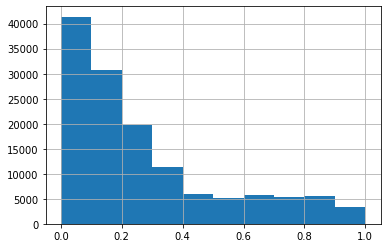

In [151]:
testset_pred['y_pred_prob'].hist()

In [152]:
testset_pred['y_pred'].value_counts()

False    132942
True       1192
Name: y_pred, dtype: int64

In [153]:
testset_pred['y_pred'].value_counts(normalize=True)

False    0.991113
True     0.008887
Name: y_pred, dtype: float64

In [154]:
testset_pred

,flow_path,starttime,endtime,hospital_id,patient_id,wav_number,hospital_id_patient_id,instance_index,split,y_pred_prob,y_pred
0,/ext_ssd/nia_vent/snu/20220831/1-161/AWF/1-161...,2022-06-15 18:45:27.250346+09:00,2022-06-15 18:46:27.250346+09:00,1,161,1,1-161,320703,test,0.138228,False
7,/ext_ssd/nia_vent/snu/20220831/1-161/AWF/1-161...,2022-06-15 18:46:27.236079+09:00,2022-06-15 18:47:27.236079+09:00,1,161,1,1-161,320710,test,0.750722,False
15,/ext_ssd/nia_vent/snu/20220831/1-161/AWF/1-161...,2022-06-15 18:47:27.252746+09:00,2022-06-15 18:48:27.252746+09:00,1,161,1,1-161,320718,test,0.089942,False
22,/ext_ssd/nia_vent/snu/20220831/1-161/AWF/1-161...,2022-06-15 18:48:27.238479+09:00,2022-06-15 18:49:27.238479+09:00,1,161,1,1-161,320725,test,0.100882,False
30,/ext_ssd/nia_vent/snu/20220831/1-161/AWF/1-161...,2022-06-15 18:49:27.255146+09:00,2022-06-15 18:50:27.255146+09:00,1,161,1,1-161,320733,test,0.112739,False
...,...,...,...,...,...,...,...,...,...,...,...
405,/ext_ssd/nia_vent/snu/원천_csv/1-200/AWF/1-200-0...,2021-12-14 15:54:22.580324+09:00,2021-12-14 15:55:22.580324+09:00,1,200,9,1-200,1559735,test,0.134338,False
412,/ext_ssd/nia_vent/snu/원천_csv/1-200/AWF/1-200-0...,2021-12-14 15:55:22.549390+09:00,2021-12-14 15:56:22.549390+09:00,1,200,9,1-200,1559742,test,0.136727,False
420,/ext_ssd/nia_vent/snu/원천_csv/1-200/AWF/1-200-0...,2021-12-14 15:56:22.566057+09:00,2021-12-14 15:57:22.566057+09:00,1,200,9,1-200,1559750,test,0.115907,False
427,/ext_ssd/nia_vent/snu/원천_csv/1-200/AWF/1-200-0...,2021-12-14 15:57:22.551790+09:00,2021-12-14 15:58:22.551790+09:00,1,200,9,1-200,1559757,test,0.951851,False


In [155]:
testset_pred['hospital_id_patient_id'].min()+'_'+testset_pred['hospital_id_patient_id'].max()

'1-161_1-200'

In [156]:
result_path = '/VOLUME/nia_vent_asynchrony/result/baseline_220818/infer'

In [157]:
path = osp.join(result_path, f'testset_{testset_pred["hospital_id_patient_id"].min()+"_"+testset_pred["hospital_id_patient_id"].max()}_{len(testset_pred)}_pred_{cutils.get_today_string(False)}.csv')
testset_pred.to_csv(path)
path

'/VOLUME/nia_vent_asynchrony/result/baseline_220818/infer/testset_1-161_1-200_134134_pred_2022-09-21.csv'

prediction 합치기

In [82]:
result_path

'/VOLUME/nia_vent_asynchrony/result/baseline_220818/infer'

In [ ]:
fn = glob.glob(result_path+'/test*_tmp*')
ls = []
for fi in fn:
    ls.append(pd.read_csv(fi, index_col=0))

In [ ]:
testset_pred = pd.concat(ls)

In [ ]:
testset_pred['hospital_id_patient_id'].nunique()

In [ ]:
testset_pred['hospital_id_patient_id'].min()

In [ ]:
testset_pred['hospital_id_patient_id'].max()

In [ ]:
testset_pred['conf_matrix'] = ''
testset_pred.loc[(testset_pred['y_target'])&(testset_pred['y_pred']),'conf_matrix']='tp'
testset_pred.loc[(~testset_pred['y_target'])&(testset_pred['y_pred']),'conf_matrix']='fp'
testset_pred.loc[(testset_pred['y_target'])&(~testset_pred['y_pred']),'conf_matrix']='fn'
testset_pred.loc[(~testset_pred['y_target'])&(~testset_pred['y_pred']),'conf_matrix']='tn'

In [ ]:
pd.crosstab(testset_pred['y_pred'], testset_pred['label'].isin([2,1]))

In [ ]:
pd.crosstab(testset_pred['y_pred'], testset_pred['label'])

In [ ]:
testset_pred['conf_matrix'].value_counts()

In [ ]:
testset_target = testset.y_data.squeeze(-1).float()
metrics = ['prec','recall','f1','f2','specificity',
                     'tn','fp','fn','tp',
                     'auroc','auprc']
calculate_any_metrics(testset_target, metrics, probs=y_prob, threshold=0.5)

In [ ]:
pd.Series(y_prob).hist()

In [ ]:
dat

In [ ]:
dat['hospital_id_patient_id'].str[0]

In [ ]:
dat['data'].head().apply(lambda x: np.nanmedian(x, axis=0))